# **导入库函数**

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import os
import PIL
import skimage
from skimage import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from torch.utils.data import DataLoader
from tqdm import tqdm
seed = 123
import cv2
import xml.etree.ElementTree as ET
torch.manual_seed(seed)
from collections import Counter

# **模型的架构**

In [4]:
architecture_config = [
    #Tuple: (kernel_size, number of filters, strides, padding)
    (7, 64, 2, 3),
    #"M" = Max Pool Layer
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    #List: [(tuple), (tuple), how many times to repeat]
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
    #Doesnt include fc layers
]

In [5]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)
        
    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))
    
class YoloV1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(YoloV1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)
        
    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))
    
    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels
        
        for x in architecture:
            if type(x) == tuple:
                layers += [CNNBlock(in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3])]
                in_channels = x[1]
            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            elif type(x) == list:
                conv1 = x[0] #Tuple
                conv2 = x[1] #Tuple
                repeats = x[2] #Int
                
                for _ in range(repeats):
                    layers += [CNNBlock(in_channels, conv1[1], kernel_size=conv1[0], stride=conv1[2], padding=conv1[3])]
                    layers += [CNNBlock(conv1[1], conv2[1], kernel_size=conv2[0], stride=conv2[2], padding=conv2[3])]
                    in_channels = conv2[1]
                    
        return nn.Sequential(*layers)
    
    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes                                                                                                                                                                                                                                    
        return nn.Sequential(nn.Flatten(), nn.Linear(1024 * S * S, 4096), nn.Dropout(0.0), nn.LeakyReLU(0.1), nn.Linear(4096, S * S * (C + B * 5)))
    #The last layer will be reshaped to (S, S, 13) where C+B*5 = 13 (3 classes and 2 bboxes to predict in each cell)

# **定义一些常用的函数**

# **IoU计算**

In [6]:
def intersection_over_union(boxes_preds, boxes_labels, box_format='midpoint'):
    """
    Calculates intersection over union
    
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes are (x,y,w,h) or (x1,y1,x2,y2) respectively.
    
    Returns:
        tensor: Intersection over union for all examples
    """
    # boxes_preds shape is (N, 4) where N is the number of bboxes
    # boxes_labels shape is (n, 4)
    
    # box1 is predicted, box2 is ground-truth
    if box_format == 'midpoint':
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
        
    if box_format == 'corners':
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4] # Output tensor should be (N, 1). If we only use 3, we go to (N)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1) # upper left of intersection area
    y1 = torch.max(box1_y1, box2_y1) # upper left of intersection area
    x2 = torch.min(box1_x2, box2_x2) # lower right of intersection area  
    y2 = torch.min(box1_y2, box2_y2) # lower right of intersection area
    
    #.clamp(0) is for the case when they don't intersect. Since when they don't intersect, one of these will be negative so that should become 0
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    
    return intersection / (box1_area + box2_area - intersection + 1e-6)

# **非极大值抑制**

In [7]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

# **mAP计算**

In [8]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision 
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)
            

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration (calculate the area under curve to do the mAP)
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [9]:
def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes



def convert_cellboxes(predictions, S=7, C=3):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, C+2*5) #(batch_size, 7, 7, 13)
    bboxes1 = predictions[..., C + 1:C + 5] #(batch_size, 7, 7, 4)
    bboxes2 = predictions[..., C + 6:C + 10]
    scores = torch.cat(
        #          prob1                             prob2 
        (predictions[..., C].unsqueeze(0), predictions[..., C + 5].unsqueeze(0)), dim=0
    )
    # Get best conf box
    best_box = scores.argmax(0).unsqueeze(-1) # (batch_size, 7, 7, 1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2 # (batch_size, 7, 7, 4)
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1) # (batch_size, 7, 7, 1)
    x = 1 / S * (best_boxes[..., 0:1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3)) # just change x, y
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 5]).unsqueeze(-1)
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1)

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def save_checkpoint(state, filename="my_checkpoint.pth"):
    print("=> Saving checkpoint")
    torch.save(state, filename)
    
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

# **数据预处理**

In [11]:
# files_dir = '/home/mengmeng/Teaching/OD_demos/fruit/train_zip/train/'
# test_dir = '/home/mengmeng/Teaching/OD_demos/fruit/test_zip/test/'
files_dir = r'C:\Users\17216\Desktop\ai_lab\ch05\appledataset_orignal\train'
test_dir = r'C:\Users\17216\Desktop\ai_lab\ch05\appledataset_orignal\test'

images = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
annots = []
for image in images:
    annot = image[:-4] + '.xml'
    annots.append(annot)
    
images = pd.Series(images, name='images')
annots = pd.Series(annots, name='annots')
df = pd.concat([images, annots], axis=1)
df = pd.DataFrame(df)

test_images = [image for image in sorted(os.listdir(test_dir))
                        if image[-4:]=='.jpg']

test_annots = []
for image in test_images:
    annot = image[:-4] + '.xml'
    test_annots.append(annot)

test_images = pd.Series(test_images, name='test_images')
test_annots = pd.Series(test_annots, name='test_annots')
test_df = pd.concat([test_images, test_annots], axis=1)
test_df = pd.DataFrame(test_df)

In [12]:
class FruitImagesDataset(torch.utils.data.Dataset):
    def __init__(self, df=df, files_dir=files_dir, S=7, B=2, C=3, transform=None):
        self.annotations = df
        self.files_dir = files_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.files_dir, self.annotations.iloc[index, 1])
        boxes = []
        tree = ET.parse(label_path)
        root = tree.getroot()
        
        class_dictionary = {'apple':0, 'banana':1, 'orange':2}
    
        if(int(root.find('size').find('height').text) == 0):
            filename = root.find('filename').text
            img = Image.open(self.files_dir + '/' + filename)
            img_width, img_height = img.size
            
            for member in root.findall('object'):
            
                klass = member.find('name').text
                klass = class_dictionary[klass]
            
                # bounding box
                xmin = int(member.find('bndbox').find('xmin').text)
                xmax = int(member.find('bndbox').find('xmax').text)
            
                ymin = int(member.find('bndbox').find('ymin').text)
                ymax = int(member.find('bndbox').find('ymax').text)
                
                centerx = ((xmax + xmin) / 2) / img_width
                centery = ((ymax + ymin) / 2) / img_height
                boxwidth = (xmax - xmin) / img_width
                boxheight = (ymax - ymin) / img_height
            
            
                boxes.append([klass, centerx, centery, boxwidth, boxheight])
            
        elif(int(root.find('size').find('height').text) != 0):
            
            for member in root.findall('object'):
            
                klass = member.find('name').text
                klass = class_dictionary[klass]
            
                                # bounding box
                xmin = int(member.find('bndbox').find('xmin').text)
                xmax = int(member.find('bndbox').find('xmax').text)
                img_width = int(root.find('size').find('width').text)
            
                ymin = int(member.find('bndbox').find('ymin').text)
                ymax = int(member.find('bndbox').find('ymax').text)
                img_height = int(root.find('size').find('height').text)
                
                centerx = ((xmax + xmin) / 2) / img_width
                centery = ((ymax + ymin) / 2) / img_height
                boxwidth = (xmax - xmin) / img_width
                boxheight = (ymax - ymin) / img_height
            
            
                boxes.append([klass, centerx, centery, boxwidth, boxheight])

                
        boxes = torch.tensor(boxes)
        img_path = os.path.join(self.files_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        image = image.convert("RGB")

        if self.transform:
            # image = self.transform(image)
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5*self.B)) #(7, 7, 3 + 5)
        
        # Label matrix looks like this:
        #  [class1, class2, ... ,classn, 
        #   prob, xcenter, ycenter, width, height]
        
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            #print(box.tolist()) #[0.0, 0.48567333817481995, 0.5214899778366089, 0.9255014061927795, 0.9570200443267822]
            class_label = int(class_label)

            # i,j represents the cell row and cell column contains the bbox
            i, j = int(self.S * y), int(self.S * x)
            
            # x_cell, y_cell is bbox coor from 0 to 1 relative to the cell it belonged
            x_cell, y_cell = self.S * x - j, self.S * y - i
            
            #print(i, j, x_cell, y_cell)

            """
            Calculating the width and height of cell of bounding box,
            relative to the cell is done by the following, with
            width as the example:
            
            width_pixels = (width*self.image_width)
            cell_pixels = (self.image_width)
            
            Then to find the width relative to the cell is simply:
            width_pixels/cell_pixels, simplification leads to the
            formulas below.
            """
            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            # If no object already found for specific cell i,j
            # Note: This means we restrict to ONE object
            # per cell!

            if label_matrix[i, j, self.C] == 0: #Prob that there is an object in this bbox
                # Set that there exists an object (because we have the bbox here!)
                label_matrix[i, j, self.C] = 1

                # Box coordinates
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 4:8] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix


# **Loss计算**

In [13]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=3):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper 20, in dataset 3),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted) so remove the BATCH_SIZE
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., self.C + 1:self.C + 5], target[..., self.C + 1:self.C + 5])
        iou_b2 = intersection_over_union(predictions[..., self.C + 6:self.C + 10], target[..., self.C + 1:self.C + 5])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0) 
        exists_box = target[..., self.C].unsqueeze(3)  # in paper this is Iobj_i, 
                                                       # each cell is 0(no obj) or 1(obj)
                                                       # make each value in cell
                                                       # become a list contain that value
    

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., self.C + 6:self.C + 10]
                + (1 - bestbox) * predictions[..., self.C + 1:self.C + 5]
            )
        )

        box_targets = exists_box * target[..., self.C + 1:self.C + 5]

        # Take sqrt of width, height of boxes to ensure that we treat small and large box equal
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2), 
            torch.flatten(box_targets, end_dim=-2),
            
            # prediction shape is (1, 7, 7, 4) so when flatten with end_dim = -2 
            # its return's shape is (1*7, 7, 4) = (7, 7, 4)
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., self.C + 5:self.C + 6] + (1 - bestbox) * predictions[..., self.C:self.C + 1]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., self.C:self.C + 1]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #
        # Punish all because it is a False Positive prediction
        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C:self.C + 1], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C + 1], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C + 5:self.C + 6], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C + 1], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :self.C], end_dim=-2),
            torch.flatten(exists_box * target[..., :self.C], end_dim=-2)
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

# **模型训练**

In [14]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16 # 64 in original paper but resource exhausted error otherwise.
WEIGHT_DECAY = 0
EPOCHS = 5
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "model.pth"

In [15]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []
    
    # 利用model，x和y计算loss，并且求均值mean_loss
    for batch_idx, (x, y) in enumerate(loop):
        pass
        
    print(f"Mean loss was {sum(mean_loss) / len(mean_loss)}")
    return sum(mean_loss) / len(mean_loss)

In [16]:
def test_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []
    
    # 利用model，x和y计算测试loss，并且求均值mean_loss
    for batch_idx, (x, y) in enumerate(loop):
        pass
        
    print(f"Mean test loss was {sum(mean_loss) / len(mean_loss)}")
    return sum(mean_loss) / len(mean_loss)

In [17]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor()])

In [18]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [19]:
def main():
    # 实例化YoloV1的模型
    pass
    #实例化优化器
    pass
    # 实例化调度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1, patience=3, mode='max', verbose=True)
    # 实例化损失类
    pass

    if LOAD_MODEL:
        # 加载模型
        pass
    # 实例化训练数据集
    pass

    # 实例化训练数据的dataloader
    pass

    # 实例化测试数据集
    pass

    # 实例化测试数据的dataloader
    pass
    
    # 定义若干list用于记录loss和mAP的结果
    train_loss = []
    test_loss = []
    mAP_train = []
    mAP_test = []

    # 开始训练
    for epoch in range(EPOCHS):
        # 模型切换到训练状态
        pass
        # 训练一个EPOCH，并记录train_loss
        pass        
        # 获取bounding boxes
        pass

        # 计算mAP
        pass

        # 输出mAP的值
        pass
        
        scheduler.step(mean_avg_prec)
        
        
        # 测试
        # 模型切换到评估状态
        pass
        # 测试阶段，不计算梯度。开始迭测试
        pass
        # 用训练好的模型测试数据，实时输出mAP
        pass

    # 保存模型
    pass
    return train_loss, mAP_train, test_loss, mAP_test
    



if __name__ == "__main__":
    train_loss, mAP_train, test_loss, mAP_test = main()

NameError: name 'optimizer' is not defined

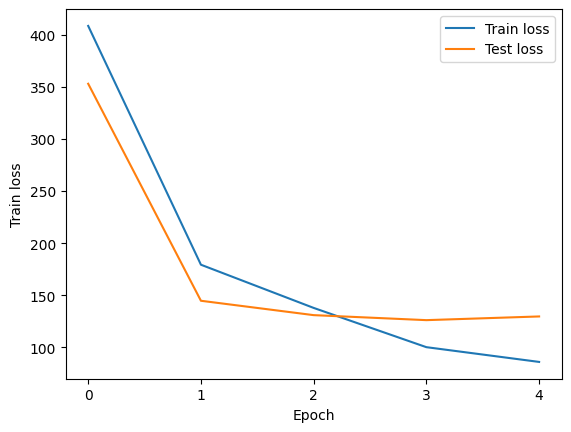

In [34]:
plt.plot(range(EPOCHS), train_loss, label = 'Train loss')
plt.plot(range(EPOCHS), test_loss, label = 'Test loss')

# plt.plt()
plt.legend()
plt.xticks(range(EPOCHS))
plt.ylabel('Train loss')
plt.xlabel('Epoch')
plt.show()

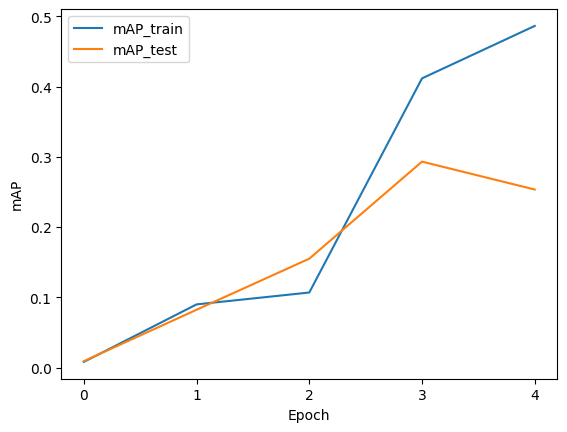

In [35]:
plt.plot(range(EPOCHS), mAP_train, label = 'mAP_train')
plt.plot(range(EPOCHS), mAP_test, label = 'mAP_test')
plt.legend()
plt.xticks(range(EPOCHS))
plt.ylabel('mAP')
plt.xlabel('Epoch')
plt.show()

# 图像可视化

In [36]:
 train_dataset = FruitImagesDataset(
        transform=transform,
        files_dir=files_dir
    )

(-0.5, 447.5, 447.5, -0.5)

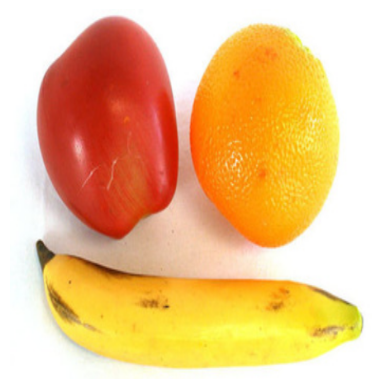

In [37]:
plt.imshow(np.rot90(train_dataset[164][0].cpu().detach().numpy().T, k=-1))
plt.axis('off')

In [38]:
test_model = YoloV1(split_size=7, num_boxes=2, num_classes=3)

In [39]:
len(test_model.darknet)

28

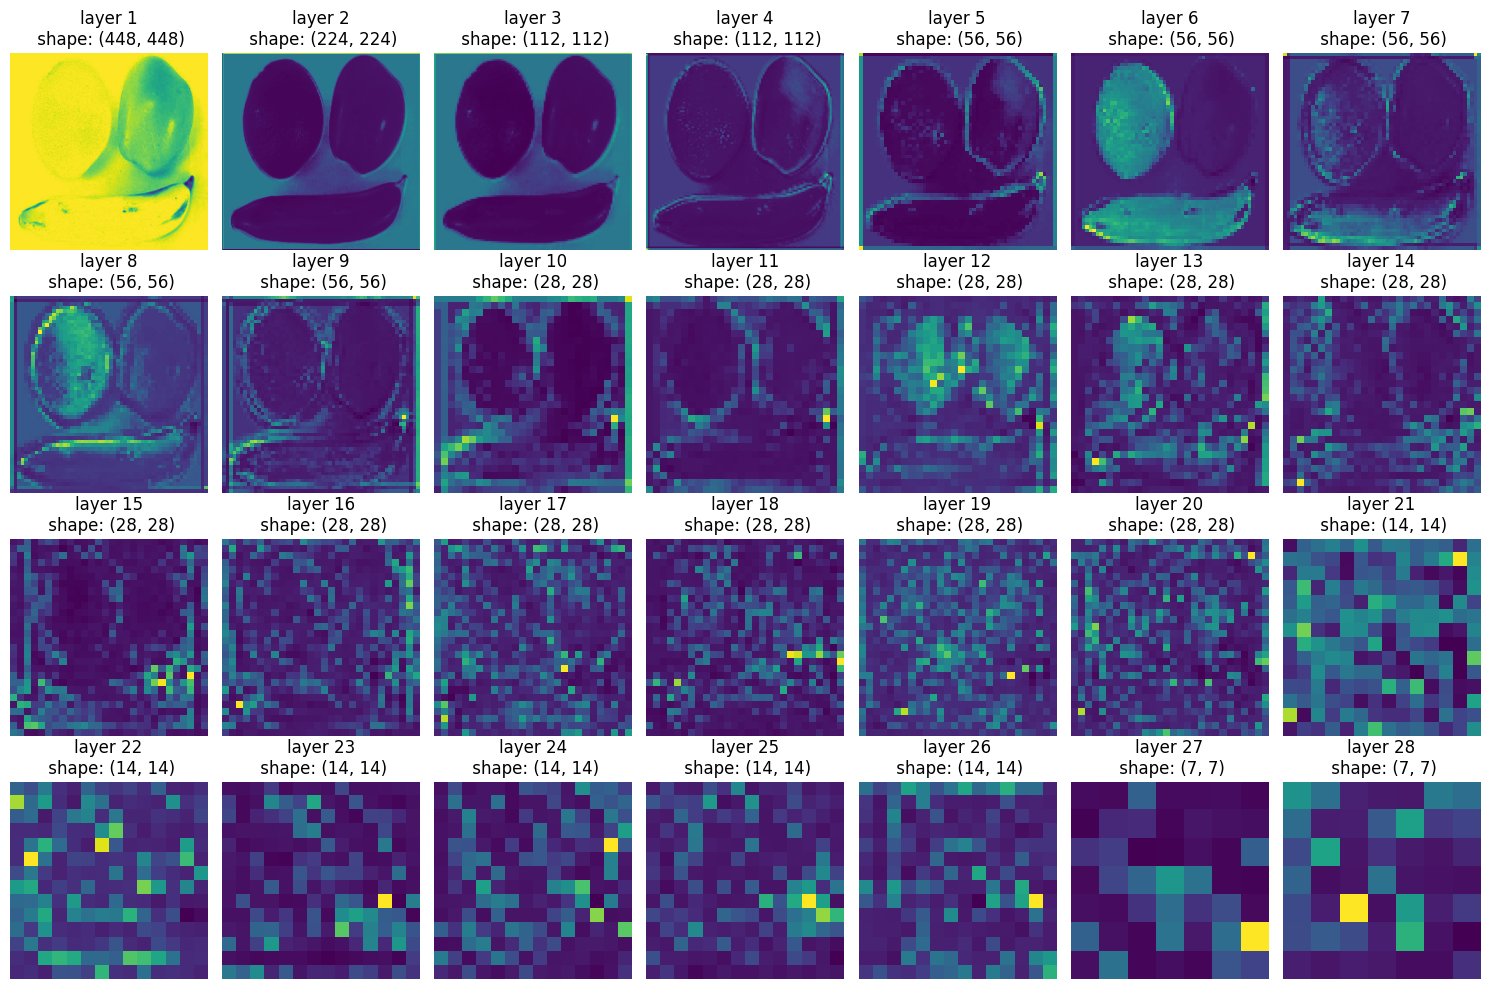

In [40]:
fig, ax = plt.subplots(4, 7, figsize=(15, 10))
for i in range(4):
    for j in range(7):
        ll = test_model.darknet[0:7*i+j](train_dataset[164][0].unsqueeze(dim=0))
        ax[i, j].imshow(ll.squeeze()[0].cpu().detach().numpy())
        ax[i, j].axis('off')
        ax[i, j].set_title(f'layer {7*i+j+1}\n shape: {ll.squeeze()[0].cpu().detach().numpy().shape}')        
        
plt.tight_layout()
#plt.show()
plt.savefig('conv_step')

# **预测**

In [ ]:
LOAD_MODEL = True
EPOCHS = 1

In [41]:
def predictions():
    # 实例化YoloV1模型
    pass
    # 实例化优化器
    pass
    # 实例化loss类
    pass

    # 加载模型
    pass
    # 定义测试数据集
    pass

    # 定义测试数据的dataloader
    pass

    for epoch in range(EPOCHS):
        # 模型切换到评估状态，预测bbox，并计算mAP
        pass
        print(f"Test mAP: {mean_avg_prec}")


predictions()

100%|██████████| 4/4 [00:01<00:00,  2.78it/s, loss=754]    


Mean loss was 1151.566650390625
Test mAP: 0.0


100%|██████████| 4/4 [00:01<00:00,  2.81it/s, loss=939]    


Mean loss was 1141.1106414794922
Test mAP: 0.0


100%|██████████| 4/4 [00:01<00:00,  2.81it/s, loss=935]    


Mean loss was 1113.740249633789
Test mAP: 0.0


100%|██████████| 4/4 [00:01<00:00,  2.81it/s, loss=882]    


Mean loss was 1046.0572814941406
Test mAP: 0.0


100%|██████████| 4/4 [00:01<00:00,  2.81it/s, loss=575]    


Mean loss was 908.4829406738281
Test mAP: 0.0


In [43]:
# 查看一下Yolo模型的结构
model = YoloV1(split_size=7, num_boxes=2, num_classes=3).to(DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
loss_fn = YoloLoss()
load_checkpoint(torch.load("model.pth"), model, optimizer)
model.eval()

=> Loading checkpoint


YoloV1(
  (darknet): Sequential(
    (0): CNNBlock(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): CNNBlock(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): CNNBlock(
      (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (5): CNNBloc

In [46]:
img, labels = train_dataset[164]
#predict = model(train_dataset[164][0].unsqueeze(dim=0))
import time
from PIL import Image
all_pred_boxes = []
all_true_boxes = []


train_idx = 0

x = img.unsqueeze(0).to(DEVICE)
labels = labels.unsqueeze(0).to(DEVICE)
# x = Image.open('/kaggle/input/dogggggg/dog.jpg')
# x, label = transform(x, torch.tensor([0, 1, 0, 1, 1, 1, 1, 1]))
# x = x.unsqueeze(0).to(DEVICE)
# print(x.shape)

start_time = time.time()
with torch.no_grad():
    predictions = model(x)

    batch_size = x.shape[0]
    #true_bboxes = cellboxes_to_boxes(labels)
    bboxes = cellboxes_to_boxes(predictions)

    for idx in range(len(bboxes)):
        nms_boxes = non_max_suppression(
            bboxes[idx],
            iou_threshold=0.5,
            threshold=0.4,
            box_format='midpoint',
        )


        #if batch_idx == 0 and idx == 0:
        #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
        #    print(nms_boxes)

        for nms_box in nms_boxes:
            all_pred_boxes.append([train_idx] + nms_box)

#         for box in true_bboxes[idx]:
#             # many will get converted to 0 pred
#             if box[1] > 0.4:
#                 all_true_boxes.append([train_idx] + box)

        train_idx += 1
end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")


Execution time: 0.010963916778564453 seconds


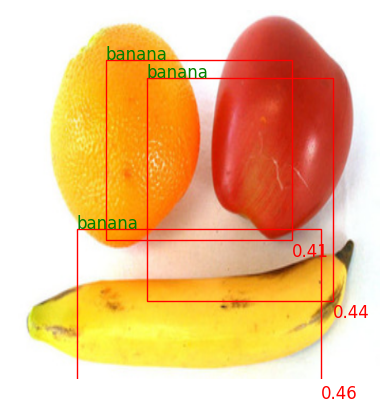

In [49]:
import matplotlib.patches as patches

# Create a figure and axis
fig, ax = plt.subplots()
ax.imshow(img.permute(1, 2, 0).cpu().detach().numpy())
# Plot a rectangle
for pred_box in all_pred_boxes:
    xcenter = pred_box[3]*img.shape[2] 
    ycenter = pred_box[4]*img.shape[1]
    width = pred_box[5]*img.shape[2]
    height = pred_box[6]*img.shape[1]
    x = xcenter - width/2
    y = ycenter - height/2
    rectangle = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rectangle)

    text_x = x
    text_y = y-1
    text = ''
    if pred_box[1] == 0:
        text = 'apple'
    elif pred_box[1] == 1:
        text = 'banana'
    else:
        text = 'orange'
    ax.text(text_x, text_y, text, fontsize=12, color='green')
    ax.text(xcenter + width/2, ycenter + height/2+20, round(pred_box[2], 2), fontsize=12, color='red')

plt.axis('off')
plt.savefig('output')
plt.show()